In [1]:
# Install necessary packages
!apt update
!apt install -y xvfb
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

Your reward for Test Episode 5 is: -130.53
Your final average reward is: -74.09


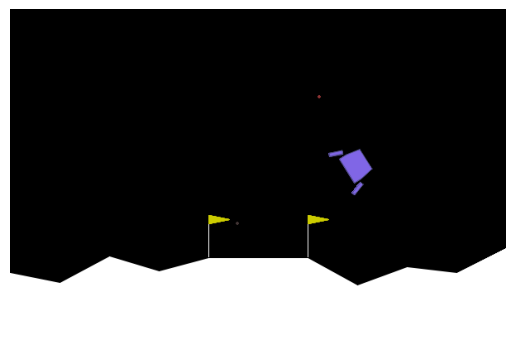

In [2]:
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from IPython import display as ipy_display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline



import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import random
from collections import defaultdict
import os
import numpy as np

seed = 1023

def fix(env, seed):
    env.reset(seed=seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



from gym import Wrapper

class CustomRewardWrapper(Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        custom_reward = 0.0
        x, y, x_vel, y_vel, angle, angular_vel, leg1_contact, leg2_contact = state
        custom_reward += -0.3 * abs(x)
        custom_reward += 0.1 * y
        custom_reward += 10.0 * (leg1_contact + leg2_contact)
        if action == 2:
            custom_reward += -0.3
        elif action in [1, 3]:
            custom_reward += -0.03
        if terminated:
            if not info.get('lander_crashed', False):
                custom_reward += 200.0
            else:
                custom_reward += -100.0
        total_reward = reward + custom_reward

        return state, total_reward, terminated, truncated, info
env = gym.make('LunarLander-v2', new_step_api=True)
fix(env, seed)
env = CustomRewardWrapper(env)

print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")
initial_state = env.reset()
print(f"Initial State: {initial_state}")
random_action = env.action_space.sample()
print(f"Random Action: {random_action}")
observation, reward, terminated, truncated, info = env.step(random_action)
done = terminated or truncated
print(f"Reward after random action: {reward}")
env.reset()

class PolicyGradientNetwork(nn.Module):
    def __init__(self, state_dim=8, hidden_dim=128, action_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        hid = F.relu(self.fc1(state))
        hid = F.relu(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

class PolicyGradientAgent():
    def __init__(self, network, lr=1e-3, gamma=0.99):
        self.network = network
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.log_probs = []
        self.rewards = []
        self.gamma = gamma

    def forward(self, state):
        return self.network(state)

    def discount_rewards(self, rewards):
        discounted = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            discounted.insert(0, R)
        discounted = torch.tensor(discounted, dtype=torch.float32)
        discounted = (discounted - discounted.mean()) / (discounted.std() + 1e-9)
        return discounted

    def learn(self):
        if not self.rewards:
            return

        discounted_rewards = self.discount_rewards(self.rewards)
        loss = 0
        for log_prob, reward in zip(self.log_probs, discounted_rewards):
            loss -= log_prob * reward
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.log_probs = []
        self.rewards = []

    def sample(self, state):
        state = torch.FloatTensor(state)
        action_probs = self.forward(state)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        self.log_probs.append(log_prob)
        return action.item()


network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network, lr=1e-3, gamma=0.99)
agent.network.train()
EPISODES = 200
BATCH_SIZE = 5
NUM_BATCH = EPISODES // BATCH_SIZE
avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    total_rewards, final_rewards = [], []
    for episode in range(BATCH_SIZE):
        state = env.reset()
        episode_rewards = []
        done = False

        while not done:
            action = agent.sample(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_rewards.append(reward)

            state = next_state

            if done:
                final_rewards.append(reward)
                total_rewards.append(sum(episode_rewards))
                agent.rewards.extend(episode_rewards)
                break
    agent.learn()

    avg_total_reward = np.mean(total_rewards)
    avg_final_reward = np.mean(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(avg_total_rewards)
plt.title("Average Total Rewards per Batch")
plt.xlabel("Batch")
plt.ylabel("Average Total Reward")

plt.subplot(1,2,2)
plt.plot(avg_final_rewards)
plt.title("Average Final Rewards per Batch")
plt.xlabel("Batch")
plt.ylabel("Average Final Reward")

plt.tight_layout()
plt.show()


model_path = "policy_gradient_lunarlander.pth"
torch.save(agent.network.state_dict(), model_path)
print(f"Model saved to {model_path}")


agent.network.eval()
NUM_OF_TEST = 5
test_total_reward = []
action_list = []

for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    total_reward = 0

    done = False
    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state)
            action_prob = agent.network(state_tensor)
            action_dist = Categorical(action_prob)
            action = action_dist.sample()
        actions.append(action.item())
        next_state, reward, terminated, truncated, info = env.step(action.item())
        state = next_state
        total_reward += reward
        done = terminated or truncated
        img.set_data(env.render(mode='rgb_array'))
        ipy_display.display(plt.gcf())
        ipy_display.clear_output(wait=True)

    print(f"Test Episode {i+1}: Total Reward = {total_reward:.2f}")
    test_total_reward.append(total_reward)

    action_list.append(actions)
print(f"Test Rewards: {test_total_reward}")
print(f"Average Test Reward: {np.mean(test_total_reward):.2f}")
print("Action list looks like ", action_list)
print("Action list shape like ", len(action_list))
distribution = defaultdict(int)
for actions in action_list:
    for action in actions:
        distribution[action] += 1

print(f"Action Distribution: {dict(distribution)}")


try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

PATH = "Action_List.npy"

action_array = np.array(action_list, dtype=object)

np.save(PATH, action_array)
print(f"Action list saved to {PATH}")
if IN_COLAB:
    files.download(PATH)
elif 'IPython' in globals():
    from IPython.display import FileLink, display
    if os.path.exists(PATH):
        display(FileLink(PATH))
    else:
        print("Action list file not found.")
else:
    print("Not in Colab or Jupyter. The Action_List.npy file is saved locally.")

import numpy as np

action_array_loaded = np.load(PATH, allow_pickle=True)
action_list_loaded = action_array_loaded.tolist()

fix(env, seed)

agent.network.eval()
test_total_reward_evaluated = []
if len(action_list_loaded) != NUM_OF_TEST:
    print("Wrong format of file !!!")
    exit(0)

for idx, actions in enumerate(action_list_loaded):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    total_reward = 0

    done = False

    for action in actions:
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        total_reward += reward
        done = terminated or truncated
        if done:
            break

        img.set_data(env.render(mode='rgb_array'))
        ipy_display.display(plt.gcf())
        ipy_display.clear_output(wait=True)

    print(f"Your reward for Test Episode {idx+1} is: {total_reward:.2f}")
    test_total_reward_evaluated.append(total_reward)

print(f"Your final average reward is: {np.mean(test_total_reward_evaluated):.2f}")
